In [1]:
%matplotlib inline
import utility

# Chapter 5: K-Nearest Neighbors Method

### Reading Data

In [2]:
import pandas as pd

data = pd.read_csv("../datasets/mushrooms.csv")
data.sample(10)

,E,F0,F1,F2,F3,F4,F5,F6,F7,F8,...,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21
346,e,x,f,y,t,l,f,w,n,n,...,s,w,w,p,w,o,p,n,v,d
5147,p,x,y,n,f,y,f,c,n,b,...,s,w,w,p,w,o,e,w,v,d
3744,e,f,y,e,t,n,f,c,b,u,...,s,w,w,p,w,o,p,n,y,d
7257,p,k,y,n,f,f,f,c,n,b,...,k,p,w,p,w,o,e,w,v,d
1760,e,x,s,g,f,n,f,w,b,n,...,s,w,w,p,w,o,e,k,a,g
4189,p,f,y,y,f,f,f,c,b,h,...,k,p,p,p,w,o,l,h,v,p
150,e,x,y,w,t,a,f,c,b,w,...,s,w,w,p,w,o,p,n,s,g
2544,e,x,y,g,t,n,f,c,b,w,...,s,w,p,p,w,o,p,k,y,d
5214,p,x,s,g,t,f,f,c,b,h,...,s,w,w,p,w,o,p,h,v,g
7879,p,k,s,n,f,f,f,c,n,b,...,s,w,w,p,w,o,e,w,v,d


In [3]:
data_of_interest = data.loc[:, ["E", "F0", "F1", "F2", "F20", "F21"]]

### Encoding categorical values

In [4]:
def numerically_encode(df):
    
    encoded_df = df.copy()
    encoders = {}
    
    for col in df.columns:
        unique_categories = df.loc[:, col].unique()
        unique_categories.sort() # in-place sorting
    
        encoder = {str: num for num, str in enumerate(unique_categories)}
        encoders[col] = encoder
    
        encoded_df.loc[:, col] = df.loc[:, col].apply(lambda x: encoder[x])
    
    return encoded_df, encoders

In [5]:
encoded_data, encoders = numerically_encode(data_of_interest)
print(encoders["E"]) # prints {'e': 0, 'p': 1}

{'e': 0, 'p': 1}


In [6]:
encoded_data.sample(10)

,E,F0,F1,F2,F20,F21
1578,0,2,0,3,0,1
78,1,5,3,4,4,5
6217,1,3,2,2,4,2
6235,1,5,2,4,4,4
7428,1,3,3,4,4,0
334,0,5,3,8,2,1
2517,0,5,0,2,5,0
2878,0,2,0,3,5,0
4286,1,5,3,3,5,0
3990,1,5,0,9,4,0


## Basic k-NN implementation

In [7]:
import math

def d(p1, p2):
    
    N = len(p1)
    squared_distance = 0
    
    for i in range(N):
        squared_distance += (p1[i] - p2[i]) ** 2
        
    return math.sqrt(squared_distance)

In [8]:
from collections import Counter

def knn_classifier(new_x, k, X_train, y_train):

    neighbors = [] # a list of tuples (distance_to_new_x, neighbor_label)
    for x, y in zip(X_train, y_train):
        distance = d(x, new_x)
        neighbors.append((distance, y))

    sorted_neighbors = sorted(neighbors, key=lambda n: n[0])
    nearest_k_neighbors = sorted_neighbors[:k]
    
    labels_counter = Counter([label for _, label in nearest_k_neighbors])
    most_voted_label = max(labels_counter.items(), key=lambda i: i[1])
    
    return most_voted_label[0]

#### Shuffling and preparing the data

In [9]:
shuffled_data = encoded_data.sample(frac=1., random_state=42)
X, y = shuffled_data.loc[:, 'F0':], shuffled_data.loc[:, "E"]
X, y = X.as_matrix(), y.as_matrix()

X_train, y_train = X[:6125], y[:6125]
X_test, y_test = X[6125:], y[6125:]

#### Testing the classifier

In [10]:
test_preds = [knn_classifier(x, 5, X_train, y_train) for x in X_test]

losses = [1. if y_pred != y else 0. for y_pred, y in zip(test_preds, y_test)]
test_error = (1. / len(test_preds)) * sum(losses)
accuracy = 1. - test_error

print("Test Error {:.3f}, Test Accuracy: {:.3f}".format(test_error, accuracy))

Test Error 0.110, Test Accuracy: 0.890


#### Measuring the classifier's execution time

In [11]:
%timeit [knn_classifier(x, 5, X_train, y_train) for x in X_test]

1min 18s ± 3.75 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Exploring NumPy

In [12]:
import numpy as np

arr1 = np.array([
    [1.2, 0.3, 0.4],
    [0.5, 2.0, 7.5]
])

print(type(arr1))
print(arr1.ndim)
print(arr1.shape)
print(arr1.dtype)

<class 'numpy.ndarray'>
2
(2, 3)
float64


#### Element-wise operations

In [13]:
arr2 = np.ones(shape=(2,3))
arr1_plus_one = arr1 + arr2

print(arr1_plus_one)

[[ 2.2  1.3  1.4]
 [ 1.5  3.   8.5]]


#### Pandas `DataFrame` underlying `ndarray`

In [14]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Broadcasting scalars

In [15]:
simpler_arr1_plus_one = arr1 + 1

print(simpler_arr1_plus_one)

[[ 2.2  1.3  1.4]
 [ 1.5  3.   8.5]]


#### Broadcasting arrays

In [16]:
another_arr1_plus_one = arr1 + np.ones(shape=(3,))

print(another_arr1_plus_one)

[[ 2.2  1.3  1.4]
 [ 1.5  3.   8.5]]


### NumPy-powered k-NN classifier

In [17]:
def faster_knn_classifier(new_x, k, X_train, y_train):
    
    neighbors_distances = np.sqrt(np.sum((X_train - new_x) ** 2, axis=1))
        
    sorted_neighbors_indecies = np.argsort(neighbors_distances)
    nearest_k_neighbors_indecies = sorted_neighbors_indecies[:k]
    nearest_k_neighbors_labels = y_train[nearest_k_neighbors_indecies]
    
    labels, votes = np.unique(nearest_k_neighbors_labels, return_counts=True)
    most_voted_label_index = np.argmax(votes)
    
    return labels[most_voted_label_index]

#### Testing the faster classifier

In [18]:
faster_test_preds = [
    faster_knn_classifier(x, 1, X_train, y_train) for x in X_test
]
faster_losses = (faster_test_preds != y_test)
faster_test_error = np.mean(faster_losses)

print("Test Error {:.4f}, Test Accuracy: {:.4f}".format(
    faster_test_error, 
    1. - faster_test_error
))

Test Error 0.1176, Test Accuracy: 0.8824


#### Measuring the faster classifier's execution time

In [19]:
%timeit [faster_knn_classifier(x, 5, X_train, y_train) for x in X_test]

1.17 s ± 9.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### k-NN with scikit-learn

In [20]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

#### Testing scikit-learn's classifier

In [21]:
sklearn_test_preds = classifier.predict(X_test)
sklearn_test_losses = (y_test != sklearn_test_preds)
sklearn_test_error = np.mean(sklearn_test_losses)

print("Test Error {:.4f}, Test Accuracy: {:.4f}".format(
    sklearn_test_error, 
    1. - sklearn_test_error
))

Test Error 0.1176, Test Accuracy: 0.8824


#### Measuring the scikit-learn classifier's execution time

In [22]:
%timeit classifier.predict(X_test)

23.4 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Distance vs Dimensionality

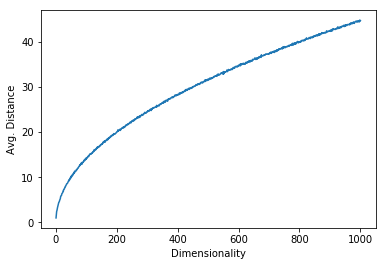

In [23]:
"""
The function called here baiscally samples two points from
a normal distribution centered at the origin point of a
given n-dimensional space, this sampling process is repeated
100 times and in each time the distance between the two points
is calculated and the average across all the 100 times is
reported for a given dimensionality. The results of all
dimesnions is then plotted.

The details of this method is outside the scope of the book 
for now if it's your first time doing these stuff. You can 
come back at later time and check the implementation of the 
method if you like.
"""

utility.plot_dist_vs_dims()

### Hyperparameter Tuning

#### Creating a validation set

In [24]:
new_X_train, X_valid = X_train[:5525], X_train[5525:]
new_y_train, y_valid = y_train[:5525], y_train[5525:]

#### Tuning the value of k with linear search

In [25]:
best_score, best_k, best_classifier = 0., None, None
for k in range(1, 21):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(new_X_train, new_y_train)
        score = classifier.score(X_valid, y_valid)
        if score > best_score:
            best_score = score
            best_k = k
            best_classifier = classifier

print("Best k: {}, Best Validation Score: {:.4f}".format(best_k, best_score))
print("Test Accuracy: {:.4f}".format(best_classifier.score(X_test, y_test)))

Best k: 11, Best Validation Score: 0.8950
Test Accuracy: 0.9005


#### Tuning the choice of metric with grid search

In [26]:
best_score, best_k, best_metric, best_classifier = 0., -1, None, None
for k in range(1, 21):
    for metric in ['euclidean', 'manhattan', 'hamming', 'canberra']:
        classifier = KNeighborsClassifier(n_neighbors=k, metric=metric)
        classifier.fit(new_X_train, new_y_train)
        score = classifier.score(X_valid, y_valid)
        if score > best_score:
            best_score = score
            best_k = k
            best_metric = metric
            best_classifier = classifier

print("Best k: {}, Best Metric: {}, Best Validation Score: {:.4f}".format(
    best_k, 
    best_metric, 
    best_score
))
print("Test Accuracy: {:.4f}".format(best_classifier.score(X_test, y_test)))

Best k: 11, Best Metric: hamming, Best Validation Score: 0.9017
Test Accuracy: 0.9065
